## Introduction and Data

In this report, I aim to model exam scores both pre-COVID (when in-person examinations took place) and post-COVID (when exams were online). I collected data from [Course Results obtained from the LSE website](https://info.lse.ac.uk/staff/divisions/academic-registrars-division/systems/what-we-do/internal/degree-and-course-results). This included scores from the last 5 years (2016/17-2020/21). Different courses use different examination methods and will experience different impacts from COVID, particularly in 2020 when LT exams were held in-person but ST exams were not. I therefore founded my model parameters based on a few first-year BSc Economics courses: MA100, EC100, EC102, and ST102. These courses are all largely examined in the ST, and they have a large body of students taking them. The methods I use should be more broadly applicable, and I urge for a more comprehensive analysis to be done with a larger dataset.

## Distributions

As my dataset did not contain the precise values of scores, I visually examined the score distribution density to identify a distribution type that would best suit the data. From my observation, the data is rather normally-distributed, but skewed slightly to the left. I've attached the distributions from these four courses below:
### MA100
![MA100](https://github.com/prakritj/exams_cheating/blob/main/images/MA100_graph.png?raw=true)

### ST102
![ST102](https://github.com/prakritj/exams_cheating/blob/main/images/ST102_graph.png?raw=true)

### EC100
![EC100](https://github.com/prakritj/exams_cheating/blob/main/images/EC100_graph.png?raw=true)

### EC102
![EC102](https://github.com/prakritj/exams_cheating/blob/main/images/EC102_graph.png?raw=true)

I recorded the $\mu_x$, $median_x$, and $\sigma_x$ for each course [here](https://github.com/prakritj/exams_cheating/blob/main/data/score_data.csv). I averaged each of these properties to obtain a final $\mu$, $median$, and $\sigma$. For this model, I set the total population of students $(n) = 1000$

As I did not have specific data regarding modes, I calculated the skewness factor using [Pearson's Median Skewness Coefficient](https://mathworld.wolfram.com/PearsonsSkewnessCoefficients.html), which considers mean, median, and standard deviation:

$$\frac{3(\mu-median)}{\sigma}$$

I defined a function, `pearson_skew`, which can generate this.

I used the `seaborn.stats.skewnorm.rvs` function to create distributions based on the $\mu, \sigma, \& \; n$ calculated. However, the arguments it takes (mean, standard deviation, and a skewness parameter) $\neq$ the overall mean, standard deviation, and skewness of the resulting distribution. This is because the function skews the original Gaussian distribution, distorting the properties of the distribution.

To resolve this, I defined a function which would check the output factors and modify the original argument parameters until it was correct within a number of decimal places defined as `acc`. As this is computationally cumbersome, I have set `acc` to 1. Any larger and some parts take too long to run.

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
#accuracy level, margin of error in decimal places
acc = 1

In [3]:
def pearson_skew(mean, median, stdev):
    return round(3*(mean-median)/stdev, acc)

In [4]:
def skew_norm(n, mean, stdev, median):
    # create the skew coeff:
    skew_coeff = pearson_skew(mean, median, stdev)
    plot_mean = mean
    plot_stdev = stdev
    plot_skew = skew_coeff
    
    skew_dist = stats.skewnorm.rvs(a=plot_skew, size = n, loc = plot_mean, scale = plot_stdev)
    
    while(round(np.mean(skew_dist), acc) != mean or round(np.std(skew_dist), acc) != stdev or pearson_skew(np.mean(skew_dist), np.median(skew_dist), np.std(skew_dist))!= skew_coeff):
        if(round(np.mean(skew_dist), acc) < mean):
            plot_mean+=10**(-1*acc -1)
        elif(round(np.mean(skew_dist), acc) > mean):
            plot_mean-=10**(-1*acc -1)
        if(round(np.std(skew_dist), acc) < stdev):
            plot_stdev+=10**(-1*acc -1)
        elif(round(np.std(skew_dist), acc) > stdev):
            plot_stdev-=10**(-1*acc -1)
        if(round(stats.skew(skew_dist), acc) < skew_coeff):
            plot_skew+=10**(-1*acc -1)
        elif(round(stats.skew(skew_dist), acc) > skew_coeff):
            plot_skew-=10**(-1*acc -1)
        skew_dist = stats.skewnorm.rvs(a=plot_skew, size = n, loc = plot_mean, scale = plot_stdev)
    
    return skew_dist

In [5]:
data = pd.read_csv('data/score_data.csv')
pre_covid = np.where(data['year'] < 2020)
pc_data = data.loc[pre_covid]
pc_median = round(np.mean(pc_data['median']), acc)
pc_stdev = round(np.mean(pc_data['stdev']), acc)
pc_mean = round(np.mean(pc_data['mean']), acc)
n = 1000
first_mark = 70

## Pre-COVID 

To start with, I will generate a distribution of pre-COVID scores. Above, I have chosen statistical parameters that are from the pre-COVID era.

One can see that there are a few scores generated which are larger than 100. Though these are not values which would exist in these contexts, I have left them for statistical purity.

I have also labelled $x=70$, the mark at which students will start earning a first. 

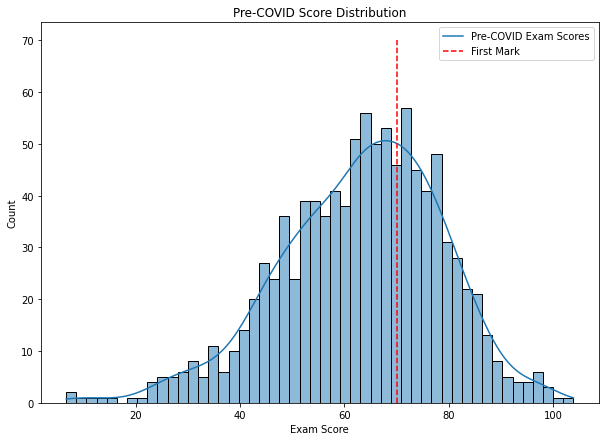

In [6]:
pc_dist = skew_norm(n=n, mean=pc_mean, stdev=pc_stdev, median=pc_median)
plt.figure(figsize=(10,7))
sns.histplot(x=pc_dist, kde = True, label = 'Exam Dist', stat='count', bins=50)
plt.vlines(first_mark, 0, 70, color='r', label='First', colors="r", linestyles='dashed')
plt.title('Pre-COVID Score Distribution')
plt.xlabel('Exam Score')
plt.legend(['Pre-COVID Exam Scores', 'First Mark'])
plt.show()

From this we can generate relevant values. `mark_prop` calculates a cumulative value for a given distribution and point.

`Seaborn` will also let us create an ecdf (empirical cumulative distribution function) based on our generated distribution.

In [7]:
def mark_cdf(mark, dist, number=n):
    sorted_dist = np.sort(dist)
    cdf_values = np.arange(number) / number
    cdf = np.interp(mark,sorted_dist, cdf_values)
    return(cdf)

In [8]:
first_prop = 1-mark_cdf(first_mark, pc_dist)
print('Approximately', str(round(100*first_prop, 2))+'% of students got a first before COVID-19 turned exams online.')

Approximately 36.2% of students got a first before COVID-19 turned exams online.


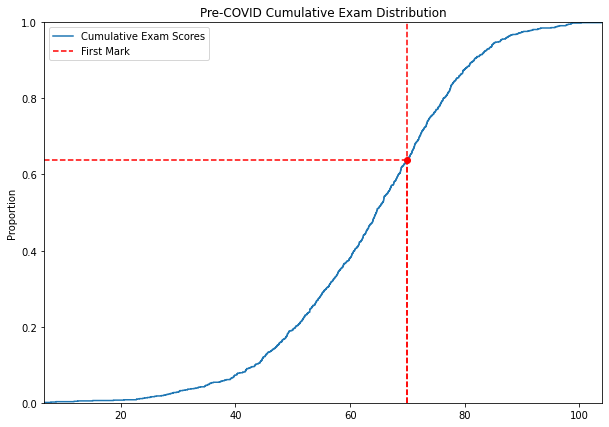

In [9]:
plt.figure(figsize=(10,7))
sns.ecdfplot(data=pc_dist)
plt.vlines(first_mark, 0, 1, color='r', label='First', colors="r", linestyles='dashed')
plt.plot([first_mark], [1-first_prop], marker = 'o', color = 'red')
plt.hlines(y=1-first_prop, xmin=np.interp(0, np.arange(n)/n, np.sort(pc_dist)), xmax=first_mark,colors='red',linestyles='dashed')
plt.vlines(x=first_mark, ymin=0, ymax = 1-first_prop, colors= 'red', linestyles='dashed')
plt.legend(['Cumulative Exam Scores', 'First Mark'])
plt.margins(0)
plt.title('Pre-COVID Cumulative Exam Distribution')
plt.show()

In [10]:
post_covid = np.where(data['year']>=2020)
post_c_data = data.loc[post_covid]
post_c_median = round(np.mean(post_c_data['median']), acc)
post_c_stdev = round(np.mean(post_c_data['stdev']), acc)
post_c_mean = round(np.mean(post_c_data['mean']), acc)
post_c_skew = pearson_skew(mean=post_c_mean, median=post_c_median, stdev = post_c_stdev)

In [11]:
print('Pre-COVID vs Post-COVID Overview \n')
print('Pre-COVID Mean: ', pc_mean)
print('Post-COVID Mean: ', post_c_mean)
print('Pre-COVID Median: ', pc_median)
print('Post-COVID Median: ', post_c_median)
print('Pre-COVID SD: ', pc_stdev)
print('Post-COVID SD: ', post_c_stdev)
print('Pre-COVID Skew: ', pearson_skew(mean=pc_mean, median=pc_median, stdev=pc_stdev))
print('Post-COVID Skew: ', round(post_c_skew, acc))

Pre-COVID vs Post-COVID Overview 

Pre-COVID Mean:  63.3
Post-COVID Mean:  69.4
Pre-COVID Median:  64.6
Post-COVID Median:  70.5
Pre-COVID SD:  15.4
Post-COVID SD:  12.1
Pre-COVID Skew:  -0.3
Post-COVID Skew:  -0.3


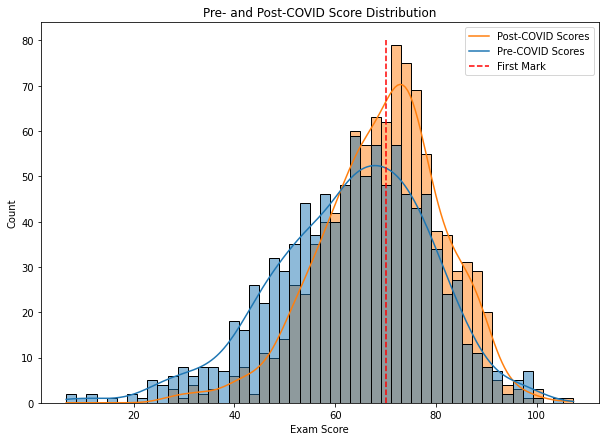

In [12]:
online_dist = skew_norm(n=n, mean=post_c_mean, stdev=post_c_stdev, median=post_c_median)
plt.figure(figsize=(10,7))
sns.histplot(data=[pc_dist, online_dist], kde = True, label = 'Exam Dist', stat='count', bins=50, multiple='layer')
plt.vlines(first_mark, 0, 80, color='r', label='First', colors="r", linestyles='dashed')
plt.title('Pre- and Post-COVID Score Distribution')
plt.xlabel('Exam Score')
plt.legend(['Post-COVID Scores', 'Pre-COVID Scores', 'First Mark'])
plt.show()

In [13]:
online_first_prop = 1-mark_cdf(first_mark, online_dist)
print(str(round(100*online_first_prop, 2))+'% of students got a first after COVID-19 turned exams online., compared to', str(round(100*first_prop, 2))+'% before COVID.')

51.85% of students got a first after COVID-19 turned exams online., compared to 36.2% before COVID.


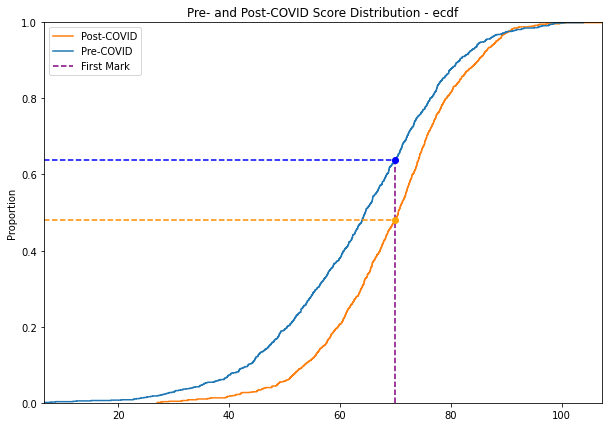

In [14]:
plt.figure(figsize=(10,7))
sns.ecdfplot([pc_dist,online_dist])
plt.vlines(x=first_mark, ymin=0, ymax = 1-first_prop, colors= 'purple', linestyles='dashed')
plt.hlines(y=1-first_prop, xmin=np.interp(0, np.arange(n)/n, np.sort(pc_dist)), xmax=first_mark,colors='blue',linestyles='dashed')
plt.hlines(y=1-online_first_prop, xmin=np.interp(0, np.arange(n)/n, np.sort(pc_dist)), xmax=first_mark,colors='darkorange',linestyles='dashed')
plt.plot([first_mark], [1-first_prop], marker = 'o', color = 'blue', linestyle = 'dashed')
plt.plot([first_mark], [1-online_first_prop], marker = 'o', color = 'orange', linestyle = 'dashed')
plt.margins(0)
plt.legend(['Post-COVID', 'Pre-COVID', 'First Mark'])
plt.title('Pre- and Post-COVID Score Distribution - ecdf')
plt.show()

## Post-COVID

What happened as examinations were held online? Primarily, we see an increase in $\mu$ and a decrease in $\sigma$. I posit that this is because of two reasons:

- Firstly, all students are able to access course materials while taking the exam. As students don't need to memorise course content, they may be able to perform better on exams. Although some exams (particularly 24-hour exams) are written with these considerations, students still appear to be performing better overall. It's also possible that previously poorly-performing students are now able to scrape by with better marks as they can refer to their notes instead of fully understanding the course material. Time is of course a factor - without time pressure, students who don't know the answer off their fingertips can produce better answers.
<br/><br/>
- Secondly, a small but notable proportion also engage in academically dishonest behaviour, particularly in the form of collaboration. Students working together will unsurprisingly score better. They may be able to 'divide and conquer' the exam workload, decreasing time pressure and minimising effort. Normally-poorly-performing students will also get a 'lift' from smarter students with whom they collaborate.

Intuitively, as the $\mu$ increases, it makes sense that the $\sigma$ decreases, since exam scores are capped at 100 and the skew does not significantly change.

### Modelling Scores in the Post-COVID Era

To effectively model scores in the post-COVID era and thus separate honest students from those who cheat, some assumptions need to be made - else, there are too many (or infinite) solutions, and many will not make sense.

- There is a certain proportion of students who cheat. I have modelled this using `prop_cheats`. It is tough for the LSE, or anyone else, to know what proportion of students cheat on their online examinations (though I would love to see such data). Therefore, we will explore results for multiple different values of `prop_cheats`.
- Cheating students must be averaging better scores than others. The question is - by how much? I have introduced a paramater for this, `cheat_adv`, and again we will explore some reasonable values for this and how it changes the distribution.
- Cheating students have a lower standard deviation. Because they collaborate, it would be reasonable to assume that they have a narrower range of scores within each group, reducing variance overall.
- The skew is the same for both cheating students and honest students. I have made this assumption because the data on post-COVID scores reflects this - there was no (significant) change in the skewness factor compared to pre-COVID scores.

With these assumptions, a machine can go through all the possibilities until the correct combination of distributions has been found. I have programmed this through the below function which returns three distributions: cheating scores, honest scores, and total scores (which combines the previous two).

### Values for `prop_cheats` and `cheat_adv`:

- `prop_cheats`: $0.1, 0.2, 0.3$
    - In other words, examine cases where 10%, 20%, 30% of students are cheaters.
- `cheat_adv`: $1.1, 1.15, 1.2, 1.25$
    - Where cheaters score, on average, 10%, 15%, 20%, or 25% better than other students.



In [42]:
class Multi_Dist:
    def __init__(self,a,b,c):
        self.a = cheat
        self.b = honest
        self.c = total

In [34]:
# create two distributions.
def multi_dist(mean, stdev, median, prop_cheats, cheat_adv=1):
    
    cheat_mean = mean+10**-acc
    cheat_std = stdev-10**-acc
    honest_mean = mean-10**-acc
    honest_std = stdev+10**-acc
    total_skew = pearson_skew(mean=mean,median=median,stdev=stdev)
    skew_factor = total_skew
    cheat_dist = stats.skewnorm.rvs(a = skew_factor, size = round(prop_cheats*n), loc = cheat_mean, scale = cheat_std)
    honest_dist = stats.skewnorm.rvs(a = skew_factor, size = round((1-prop_cheats)*n), loc = honest_mean, scale = honest_std)
    total_dist = np.append(cheat_dist, honest_dist)
    temp_total_mean = round(np.mean(total_dist), acc)
    temp_total_std = round(np.std(total_dist), acc) 
    temp_total_skew = total_skew
    
    n1 = 0
    n2 = 0

    while np.mean(cheat_dist) < cheat_adv*np.mean(honest_dist) or temp_total_mean != mean or temp_total_std != stdev or temp_total_skew != total_skew:
        if(np.mean(cheat_dist) < np.mean(honest_dist)):
            cheat_mean += 10**(-1*acc -1)
            honest_mean -= 10**(-1*acc -1)
        if(temp_total_mean < mean):
            if n1 % 2 == 0:
                cheat_mean += 10**(-1*acc -1)
            else:
                honest_mean += 10**(-1*acc -1)
            n1+=1
        elif(temp_total_mean > mean):
            if n1 % 2 == 0:
                cheat_mean -= 10**(-1*acc -1)
            else:
                honest_mean -= 10**(-1*acc -1)
            n1+=1
        if(temp_total_std < stdev):
            if n2 % 2 == 0 or cheat_std < 1:
                cheat_std += 10**(-1*acc -1)
            else:
                honest_std += 10**(-1*acc -1)
            n2+=1
        elif(temp_total_std > stdev):
            if n2 % 2 == 0 and cheat_std > 1:
                cheat_std -= 10**(-1*acc -1)
            else:
                honest_std -= 10**(-1*acc -1)
            n2+=1
        if(temp_total_skew < total_skew):
            skew_factor += 10**(-1*acc -1)
        elif(temp_total_skew > total_skew):
            skew_factor -= 10**(-1*acc -1)

        cheat_dist = stats.skewnorm.rvs(a = skew_factor, size = round(prop_cheats*n), loc = cheat_mean, scale = cheat_std)
        honest_dist = stats.skewnorm.rvs(a = skew_factor, size = round((1-prop_cheats)*n), loc = honest_mean, scale = honest_std)
        total_dist = np.append(cheat_dist, honest_dist)

        temp_total_mean = round(np.mean(total_dist), acc)
        temp_total_std = round(np.std(total_dist), acc) 
        temp_total_skew = pearson_skew(mean=np.mean(total_dist), median=np.median(total_dist), stdev=np.std(total_dist))
        # print(n1, n2)
        # print(temp_total_std)
    # print('Order: cheat_dist, honest_dist, total_dist')
    return cheat_dist, honest_dist, total_dist


In [36]:
# Already ran before and results had been output to all_dists.pickle
cheat_adv_list = [1.1, 1.15, 1.2, 1.25]
prop_cheat_list = [0.1, 0.2, 0.3]

all_dists = pd.DataFrame(columns = ['1.1', '1.15', '1.2', '1.25'], index = ['0.1', '0.2', '0.3'])

for cheat_adv in cheat_adv_list:
    #all_dists[str(cheat_adv)] = all_dists[str(cheat_adv)].astype(object)
    for prop_cheats in prop_cheat_list:
        print(prop_cheats, cheat_adv)
        a1,a2,a3=multi_dist(mean=post_c_mean, median=post_c_median, stdev= post_c_stdev, cheat_adv=cheat_adv, prop_cheats=prop_cheats)
        md = Multi_Dist(a1,a2,a3)
        all_dists.loc[str(prop_cheats), str(cheat_adv)] = md
    # print(all_dists)
all_dists.to_pickle('all_dists.pkl')

0.1 1.1
0.2 1.1
0.3 1.1
0.1 1.15
0.2 1.15
0.3 1.15
0.1 1.2
0.2 1.2
0.3 1.2
0.1 1.25
0.2 1.25
0.3 1.25


In [43]:
all_dists = pd.read_pickle('all_dists.pickle')

How do the scores of cheaters and honest students compare? Let's take a look at a few examples. First, we shall take a 'middle' value where 20% of students cheat, and cheating provides a 20% advantage.

There are some important takeaways here. Firstly, a significant proportion of cheating students got a first. We can calculate that pretty simply:

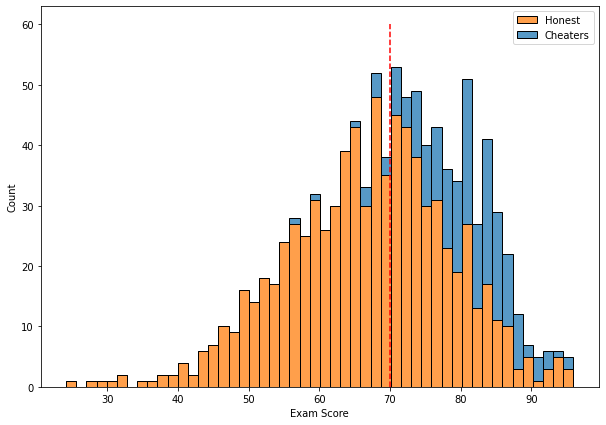

In [44]:
middle_dist = all_dists.loc['0.2','1.2']
plt.figure(figsize=(10,7))
sns.histplot([middle_dist.a,middle_dist.b], multiple='stack', stat='count', bins=50)
plt.legend(['Honest', 'Cheaters'])
plt.xlabel('Exam Score')
plt.vlines(first_mark, 0, 60, color='r', label='First', colors="r", linestyles='dashed')
plt.show()

In [45]:
mid_cheat_first = 100*(1-mark_cdf(70,middle_dist.a,number=int(0.2*n)))
mid_honest_first = 100*(1-mark_cdf(70,middle_dist.b, number=int(0.8*n)))
mid_all_first = 100*(1-mark_cdf(70,middle_dist.c))
print(str(round(mid_cheat_first, 2))+'% of cheaters got firsts!')
print(str(round(mid_honest_first, 2))+'% of honest students got firsts.')
print(str(round(mid_all_first, 2))+'% of all students got a first.')
# What % of students who got a first were cheaters?
print(str(round(100*(mid_cheat_first*0.2/mid_all_first), 2))+'% of first students were cheaters, despite making up only 20% of the population!')

93.95% of cheaters got firsts!
41.74% of honest students got firsts.
52.09% of all students got a first.
36.07% of first students were cheaters, despite making up only 20% of the population!


Ok - we see this for one such case in the distribution, but what about the rest? Make a table with all of these values

In [46]:
all_dist_prop=pd.DataFrame()
for cheat_adv in cheat_adv_list:
    for prop_cheat in prop_cheat_list:
        dist = all_dists.loc[str(prop_cheat), str(cheat_adv)]
        cheat_first = 100*(1-mark_cdf(first_mark,dist.a,number=int(prop_cheat*n)))
        all_first = 100*(1-mark_cdf(first_mark,dist.c))
        prop = 100*(cheat_first*prop_cheat/all_first)
        all_dist_prop.loc[prop_cheat, cheat_adv] = str(round(prop, 2))+'%'
print(all_dist_prop)

       1.10    1.15    1.20    1.25
0.1  14.31%  14.62%  16.22%  18.18%
0.2  27.23%  30.65%  36.07%   36.2%
0.3  38.49%  42.08%  47.98%  50.44%


[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]]


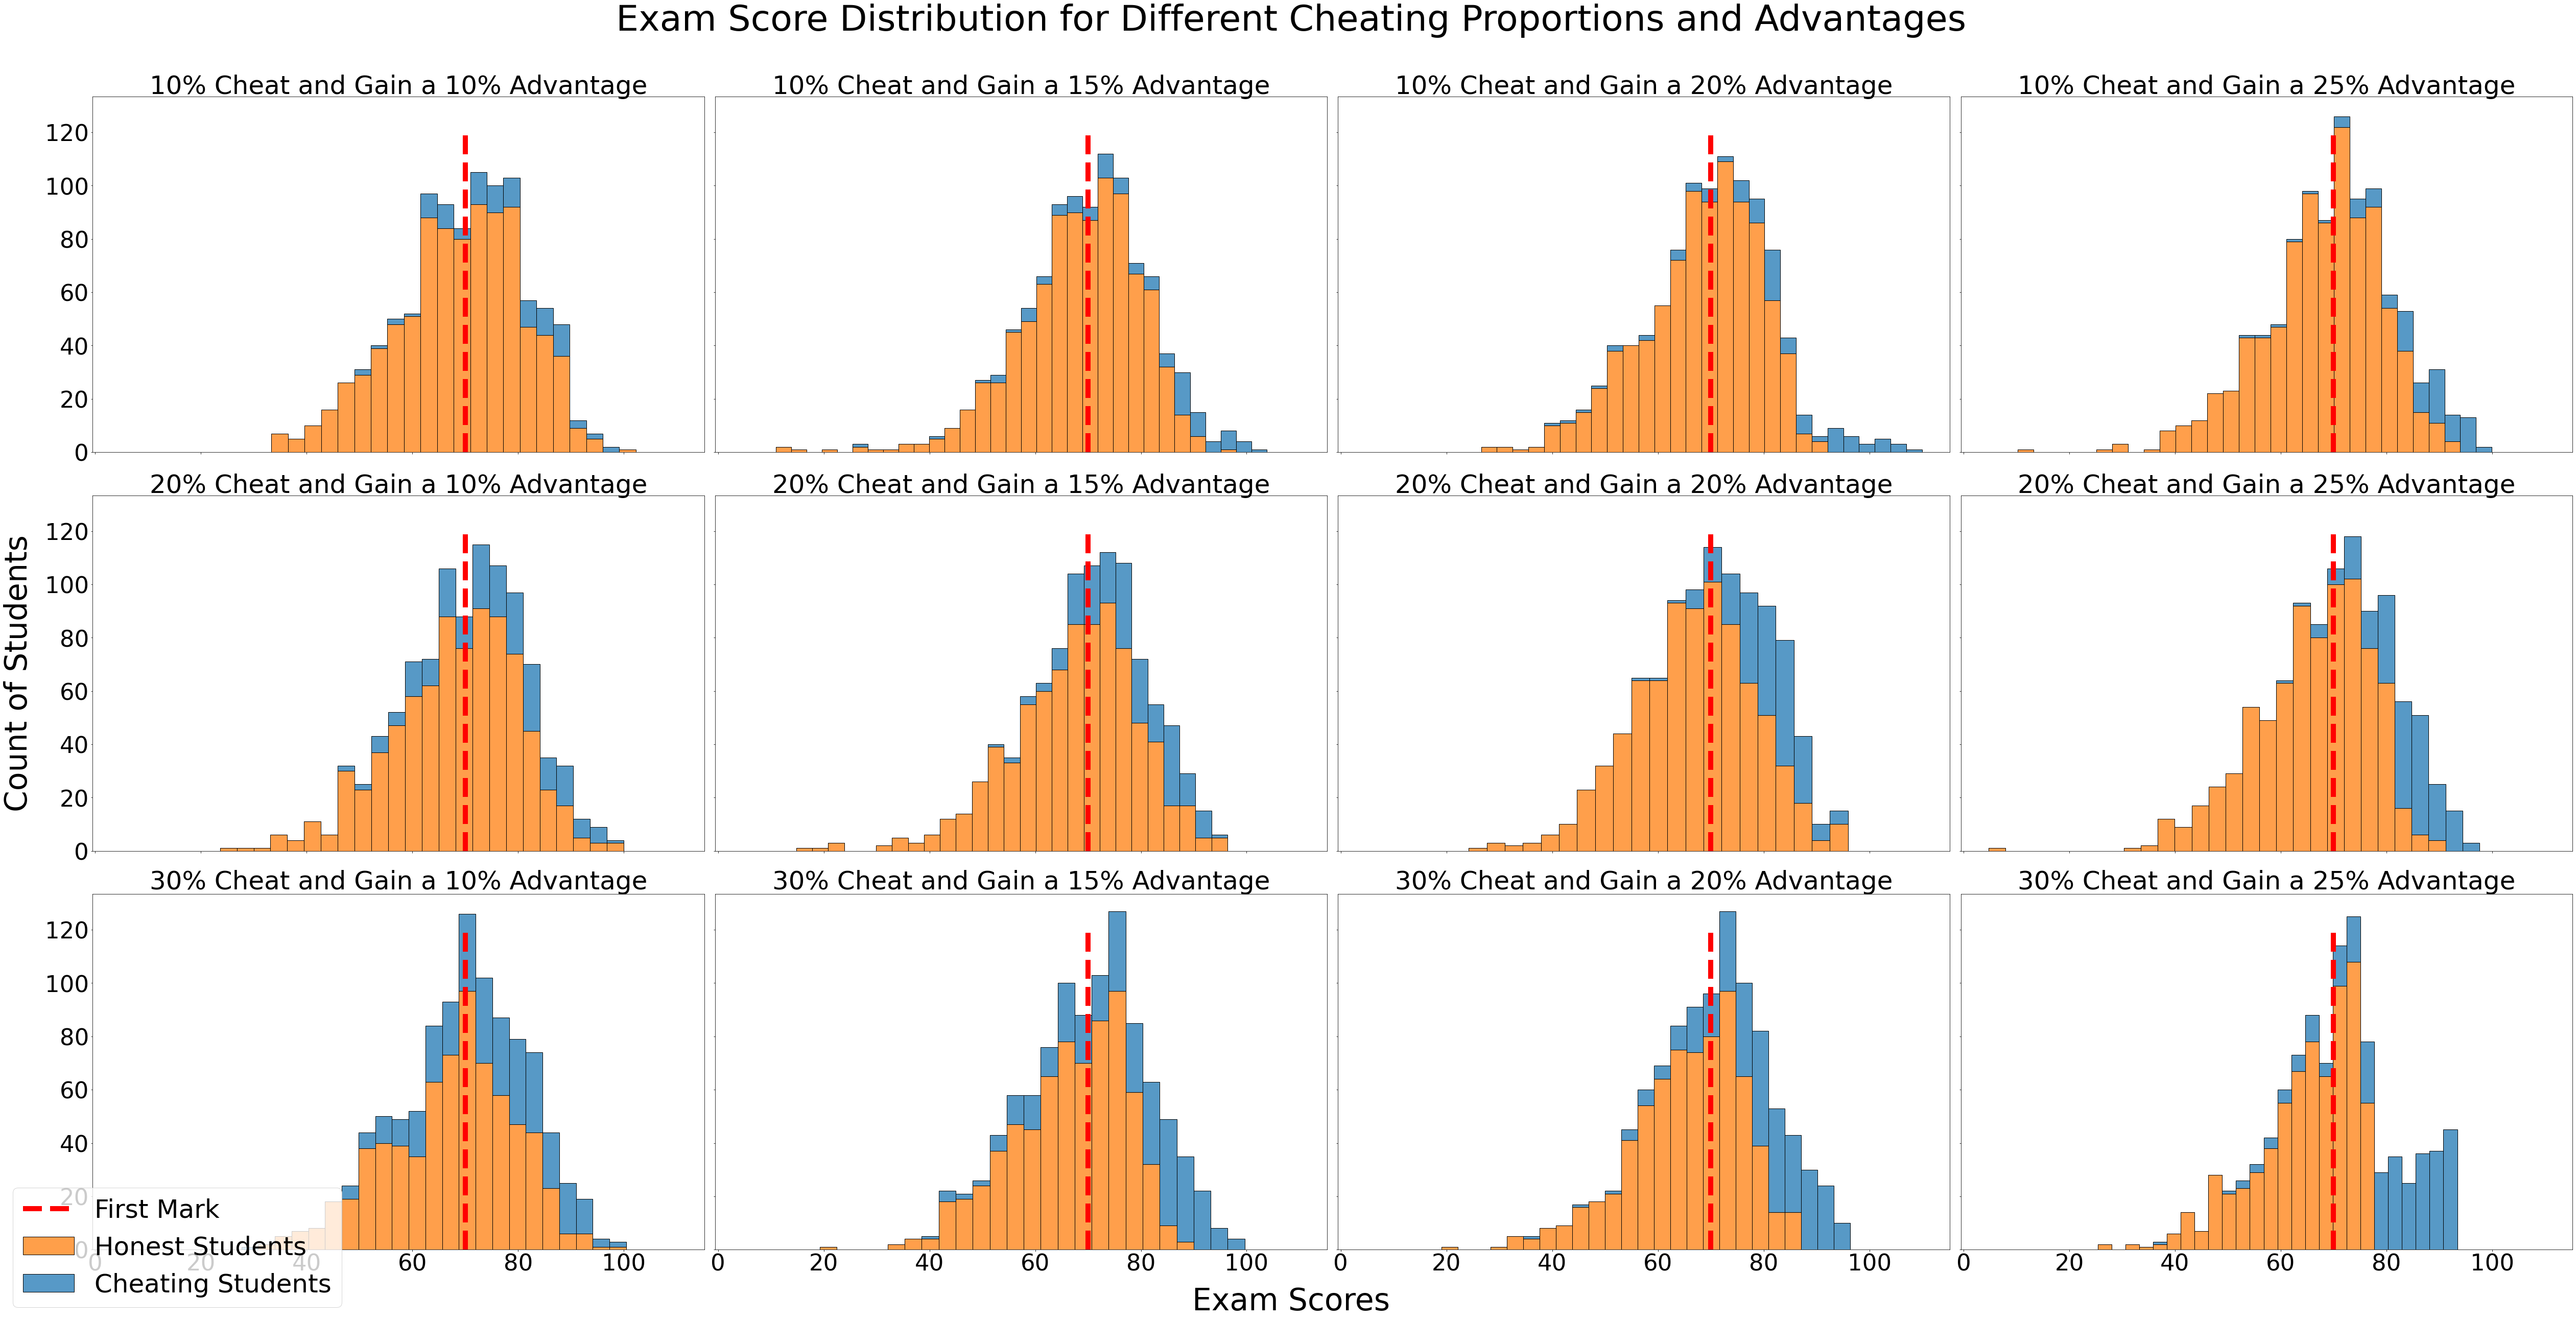

In [47]:
fig, axs = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(70,35), tight_layout=True)
print(axs)

for col in range(len(cheat_adv_list)):
    for row in range(len(prop_cheat_list)):
        plot_dist = all_dists.loc[str(prop_cheat_list[row]), str(cheat_adv_list[col])]
        sns.histplot([plot_dist.a, plot_dist.b], multiple = 'stack', ax=axs[row, col])
        axs[row, col].get_legend().remove()
        axs[row, col].tick_params(axis='both', which='major', labelsize=45)
        axs[row, col].set_ylabel('', fontsize=0)
        axs[row, col].set_title(str(round(prop_cheat_list[row]*100)) + '% Cheat and Gain a ' + str(round(cheat_adv_list[col]*100-100)) +'% Advantage', fontsize=50)
        axs[row, col].vlines(70,0,120, color='red', linestyles='dashed', linewidths = 10)
fig.legend(['First Mark', 'Honest Students', 'Cheating Students'], fontsize=50, loc='lower left')
fig.supxlabel('Exam Scores', fontsize=60, y=0)
fig.supylabel('Count of Students', fontsize=60, x=0)
plt.suptitle('Exam Score Distribution for Different Cheating Proportions and Advantages', y=1.02, fontsize=70)
plt.show()

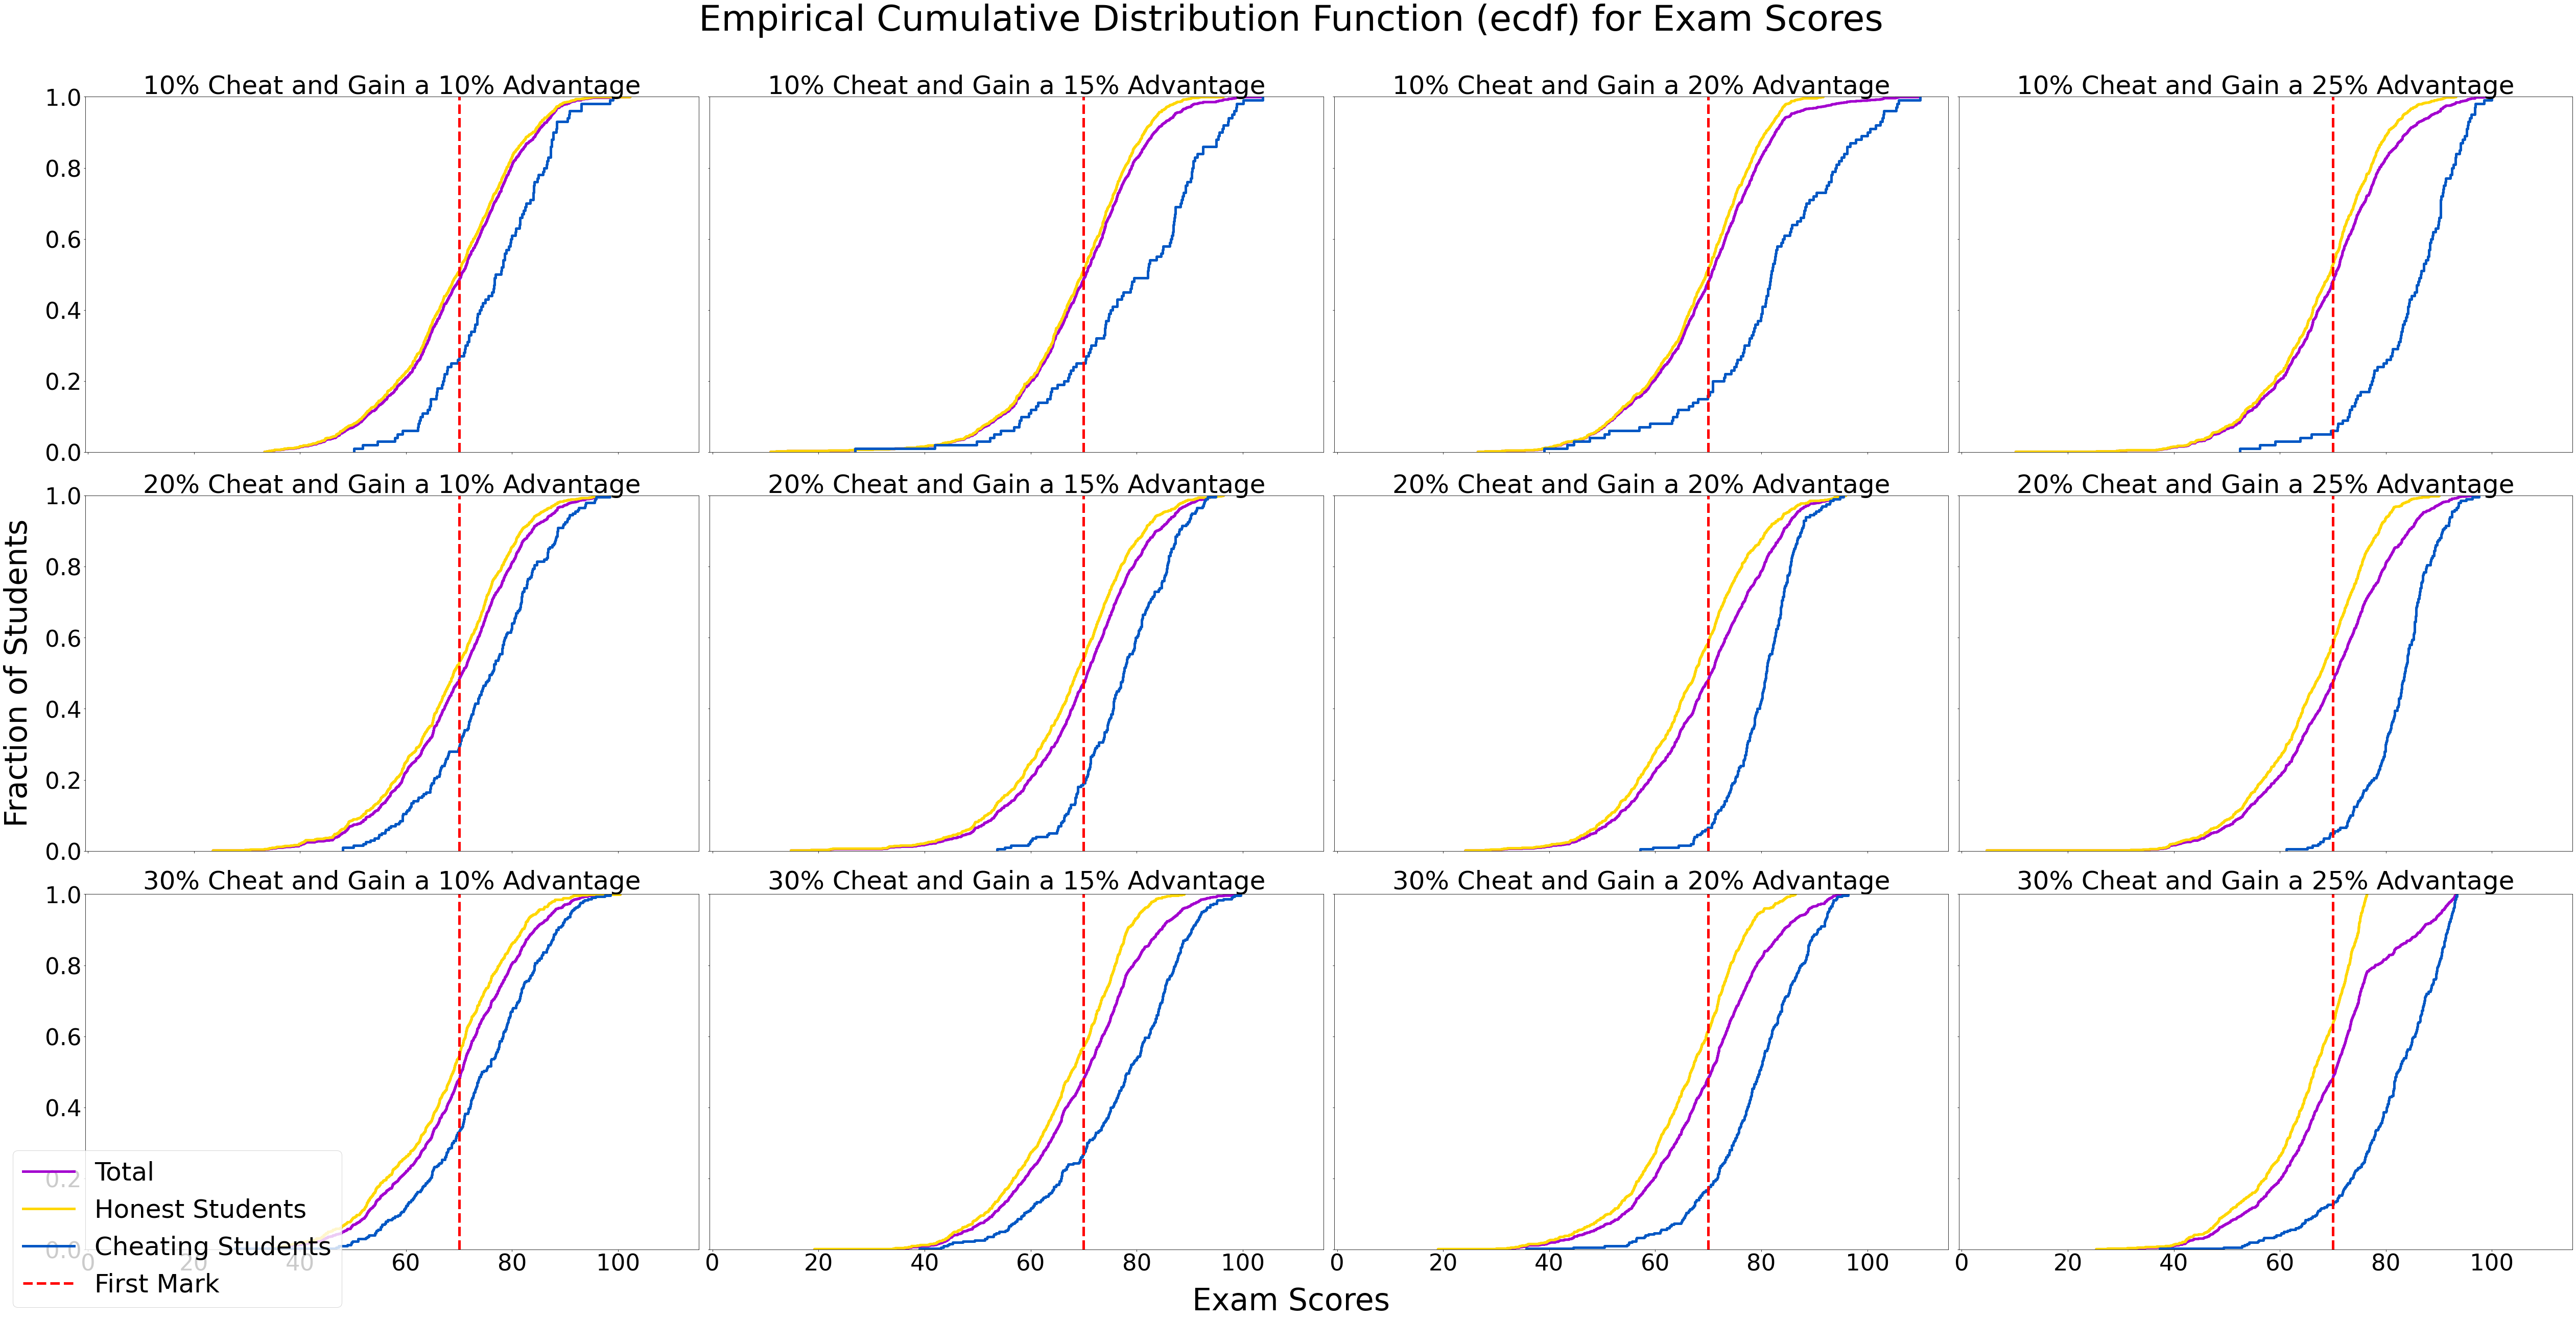

In [48]:
fig, axs = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(70,35), tight_layout=True)

for col in range(len(cheat_adv_list)):
    for row in range(len(prop_cheat_list)):
        plot_dist = all_dists.loc[str(prop_cheat_list[row]), str(cheat_adv_list[col])]
        sns.ecdfplot([plot_dist.a, plot_dist.b, plot_dist.c], ax=axs[row, col], palette='prism', linewidth=5)
        axs[row, col].get_legend().remove()
        axs[row, col].tick_params(axis='both', which='major', labelsize=45)
        axs[row, col].set_ylabel('', fontsize=0)
        axs[row, col].set_title(str(round(prop_cheat_list[row]*100)) + '% Cheat and Gain a ' + str(round(cheat_adv_list[col]*100-100)) +'% Advantage', fontsize=50)
        axs[row, col].vlines(70,0,1, color='red', linestyles='dashed', linewidths = 5)
fig.legend(['Total', 'Honest Students', 'Cheating Students', 'First Mark'], fontsize=50, loc='lower left')
fig.supxlabel('Exam Scores', fontsize=60, y=0)
fig.supylabel('Fraction of Students', fontsize=60, x=0)
plt.suptitle('Empirical Cumulative Distribution Function (ecdf) for Exam Scores', y=1.02, fontsize=70)
plt.show()

## Interpreting Results

In the above distributions, one can see how cheating students have a distinct advantage at all levels. In the ecdf, the gap between cheating students and honest students is evident, even when the advantage is small, say 10%. A greater advantage pulls the cheating curve farther away from the honest, but at the upper end of the curve, a gap forms between the honest and total curves. There is a great advantage to get high marks when cheating.

The distribution for the 30% Cheats, 25% advantage is rather abnormal. In this model, honest students don't obtain marks past 80. This seems rather unusual and would be evident in the overall distributions, so it may be more reasonable to assume that such an extreme would be unlikely to occur with our existing parameters.

Even when cheaters only make up 10% of the population and gain just a 10% advantage, they make up 14% of those who get a first. 14% is still small, but a 10% advantage indicates just 7 marks from a baseline score of 70 - it is very possible that they score far better. At a 15% advantage for 20% of the population, this number goes up to 31%.

One way to view this would be to compare it to the proportion of students who cheat. If 20% of students cheat, should we not expect that 20% of them will also get firsts? If so, we are only seeing a 10 percentage point increase (which is still sizeable, but perhaps less significant). This would assume that cheating is independent of performance, which I would doubt as students who are insecure of their abilities may prefer to cheat compared to those who don't (although I do not have data to back this up). I can speak for myself when I say that I believed I was competetent enough to score well without illicit, immoral intervention and support.

Instead - and I think the LSE may share this view - I see these % of firsts are illegitimate. If 20% of firsts were not fairly earned but the school cannot confirm those individuals (which seems to be the case), and these students get a small, 15% advantage, 30% of all first students have gotten to that level illegitimately. 

Note that this model takes in arguments for an overall distribution and creates two distributions, the total of which matches the original parameters. Thus, in our model, there is a tradeoff between the performance of students who cheat and those who don't. As the students who cheat do better (a greater advantage in our model), this implies that honest students do worse. In fact, this is also true as the proportion of students who cheat increases. In the ecdf plots, the gap between the honest and total curves increases as `prop_cheats` increases. 

All of this means that a First today means far less than it did previously. Students who got a first may be exceptionally bright - but they may also have gotten a first because they were academically dishonest. If this is a serious possibility, it would not be surprising that firms and prospective students will lose respect for the university.

### Grade Inflation and Solutions

For a university which prides itself on high standards for entry and success, it is of course critical to minimise grade inflation such that the sanctity of the LSE degree is preserved. In fact, it is not just the LSE; the [UK Government](https://www.gov.uk/government/news/universities-told-to-end-grade-inflation) has wanted to reduce grade inflation even before the COVID-era had begun. Office for Students has also recently [warned against grade inflation](https://www.thetimes.co.uk/article/85d4bad6-7e0c-11ec-bbb7-54d5cd4b43b0?shareToken=b26ec4dfe51fb84d150efd7f68830912).

Considering that many stakeholders have had an eye on grade inflation, solutions to this issue have been often discussed.

It is no easy question to answer. I'm sure the LSE has given this a lot of thought, particularly as the pandemic turned examinations online. It is difficult, if not near-on impossible, to develop examinations which are administered online and yet distinguish excelling students from mediocre ones who have a textbook open. This is especially true for timed exams, where the exam content is identical to that of an in-person exam. Examiners cannot write harder questions which require a further application of the course content to answer well.

If the LSE wishes to assess students through an online medium, it may realise that exams are not necessarily the most fair way to do so. Though changing assessment types is very challenging to accomplish successfully (and not practical where last-minute changes occur such as in the recent examination window), an assessment like a report may be a better representation of a student's understanding than an online exam-like assessment.

In these last-minute cases, however, there is not much the LSE can do. I imagine that the LSE has been reserving curving assessments as a tool of last-resort. Let me thus attempt to show the effects of assessment curves.

We saw previously that around 52% of students got a first when exams were online, compared to 35% before. What if the school wanted to restore such a standard, and return the first proportion to 35% for the overall distribution? Since the $\mu$ and $\sigma$ of the total distributions are all similar, we can estimate the new first mark using one of these total distributions.


In [50]:
sorted_online_dist = np.sort(middle_dist.c)
online_cdf_values = np.arange(n)/n
curve_first_mark = np.interp(1-0.35, online_cdf_values, sorted_online_dist)
print(str(round(curve_first_mark, 2)) + '% is the new First Mark.')

75.0% is the new First Mark.


In [51]:
all_dist_new_first_prop=pd.DataFrame()
for cheat_adv in cheat_adv_list:
    for prop_cheat in prop_cheat_list:
        dist = all_dists.loc[str(prop_cheat), str(cheat_adv)]
        new_cheat_first = 100*(1-mark_cdf(curve_first_mark,dist.a,number=int(prop_cheat*n)))
        new_all_first = 100*(1-mark_cdf(curve_first_mark,dist.c))
        new_prop = 100*(new_cheat_first*prop_cheat/new_all_first)
        all_dist_new_first_prop.loc[prop_cheat, cheat_adv] = str(round(new_prop, 2))+'%'
print(all_dist_new_first_prop)

       1.10    1.15    1.20    1.25
0.1  16.17%  18.38%  22.95%  26.08%
0.2  30.86%  37.14%  46.11%  50.43%
0.3  44.19%  51.66%  63.22%  80.15%


[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]]


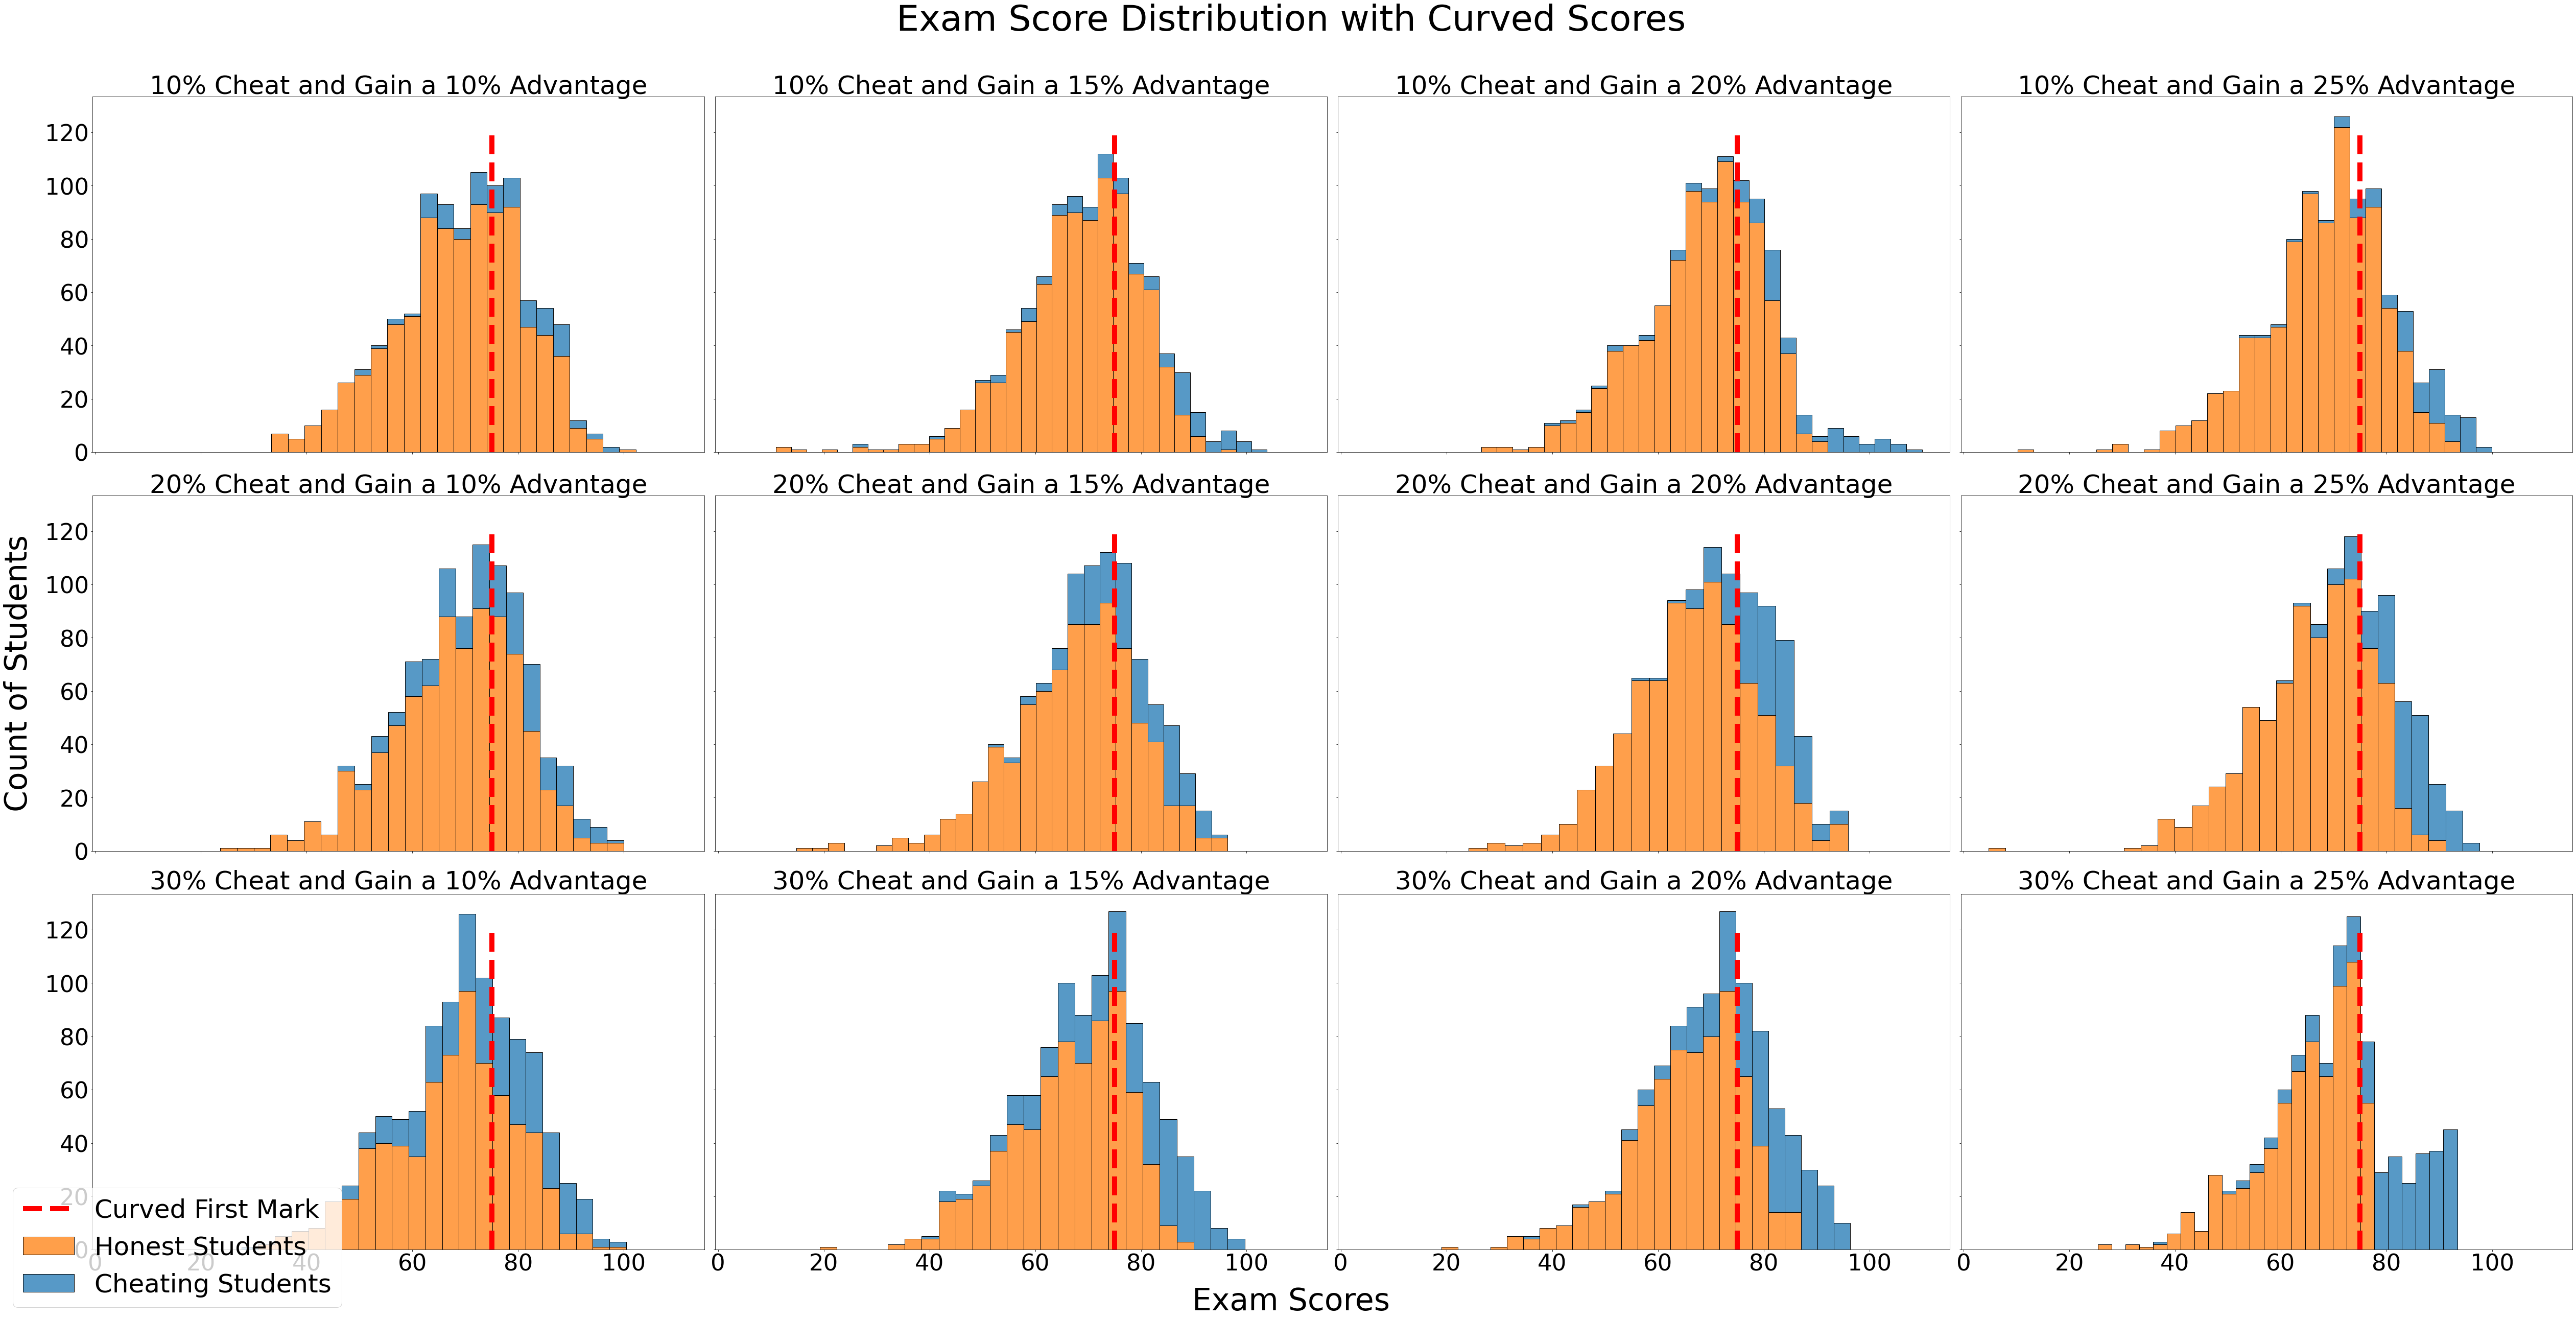

In [52]:
fig, axs = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(70,35), tight_layout=True)
print(axs)

for col in range(len(cheat_adv_list)):
    for row in range(len(prop_cheat_list)):
        plot_dist = all_dists.loc[str(prop_cheat_list[row]), str(cheat_adv_list[col])]
        sns.histplot([plot_dist.a, plot_dist.b], multiple = 'stack', ax=axs[row, col])
        axs[row, col].get_legend().remove()
        axs[row, col].tick_params(axis='both', which='major', labelsize=45)
        axs[row, col].set_ylabel('', fontsize=0)
        axs[row, col].set_title(str(round(prop_cheat_list[row]*100)) + '% Cheat and Gain a ' + str(round(cheat_adv_list[col]*100-100)) +'% Advantage', fontsize=50)
        axs[row, col].vlines(curve_first_mark,0,120, color='red', linestyles='dashed', linewidths = 10)
fig.legend(['Curved First Mark', 'Honest Students', 'Cheating Students'], fontsize=50, loc='lower left')
fig.supxlabel('Exam Scores', fontsize=60, y=0)
fig.supylabel('Count of Students', fontsize=60, x=0)
plt.suptitle('Exam Score Distribution with Curved Scores', y=1.02, fontsize=70)
plt.show()

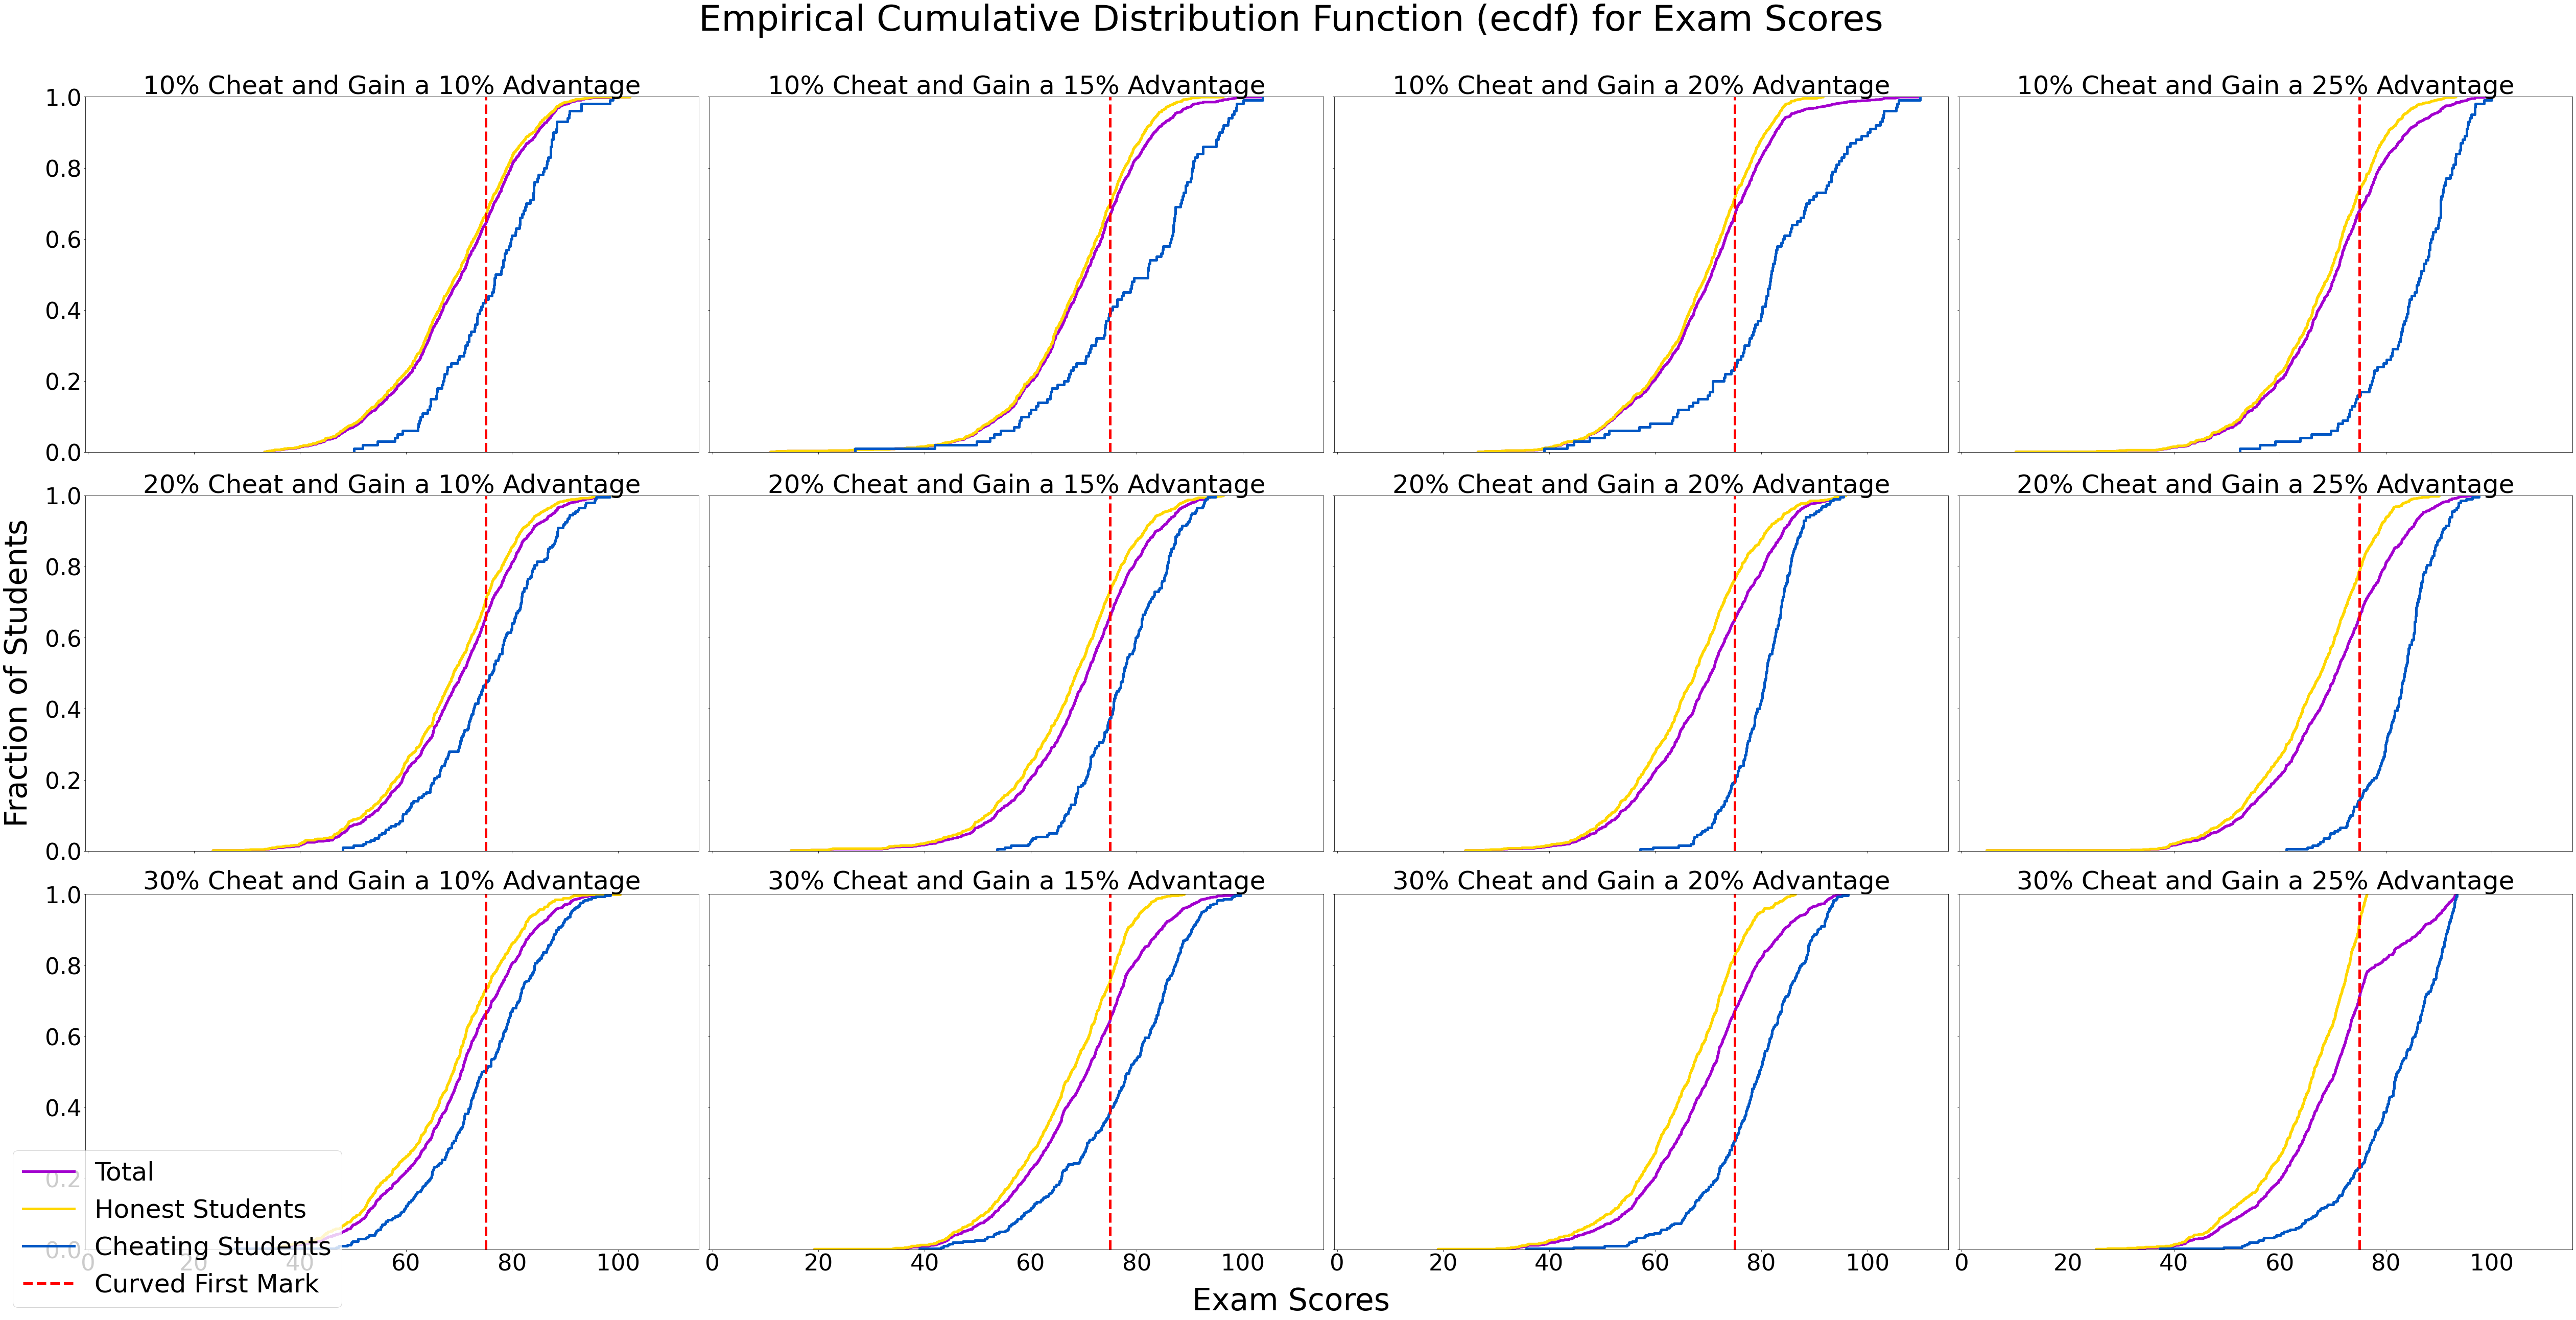

In [53]:
fig, axs = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(70,35), tight_layout=True)

for col in range(len(cheat_adv_list)):
    for row in range(len(prop_cheat_list)):
        plot_dist = all_dists.loc[str(prop_cheat_list[row]), str(cheat_adv_list[col])]
        sns.ecdfplot([plot_dist.a, plot_dist.b, plot_dist.c], ax=axs[row, col], palette='prism', linewidth=5)
        axs[row, col].get_legend().remove()
        axs[row, col].tick_params(axis='both', which='major', labelsize=45)
        axs[row, col].set_ylabel('', fontsize=0)
        axs[row, col].set_title(str(round(prop_cheat_list[row]*100)) + '% Cheat and Gain a ' + str(round(cheat_adv_list[col]*100-100)) +'% Advantage', fontsize=50)
        axs[row, col].vlines(curve_first_mark,0,1, color='red', linestyles='dashed', linewidths = 5)
fig.legend(['Total', 'Honest Students', 'Cheating Students', 'Curved First Mark'], fontsize=50, loc='lower left')
fig.supxlabel('Exam Scores', fontsize=60, y=0)
fig.supylabel('Fraction of Students', fontsize=60, x=0)
plt.suptitle('Empirical Cumulative Distribution Function (ecdf) for Exam Scores', y=1.02, fontsize=70)
plt.show()

I stated earlier that at the upper end of the ecdf, a (larger) gap forms between the honest and total curves. Thus it is not surprising that with this new first mark at $75\%$, cheating students will form a larger percentage of firsts than they did otherwise.

We can see this gap clearly in the above table. More cheating students are getting firsts instead of honest students. I quantify this in percentage points below:

In [54]:
all_dist_new_first_float=pd.DataFrame()
for cheat_adv in cheat_adv_list:
    for prop_cheat in prop_cheat_list:
        dist = all_dists.loc[str(prop_cheat), str(cheat_adv)]
        new_cheat_first = 100*(1-mark_cdf(curve_first_mark,dist.a,number=int(prop_cheat*n)))
        new_all_first = 100*(1-mark_cdf(curve_first_mark,dist.c))
        new_prop = 100*(new_cheat_first*prop_cheat/new_all_first)
        all_dist_new_first_float.loc[prop_cheat, cheat_adv] = round(new_prop, 2)

all_dist_prop_float=pd.DataFrame()
for cheat_adv in cheat_adv_list:
    for prop_cheat in prop_cheat_list:
        dist = all_dists.loc[str(prop_cheat), str(cheat_adv)]
        cheat_first = 100*(1-mark_cdf(first_mark,dist.a,number=int(prop_cheat*n)))
        all_first = 100*(1-mark_cdf(first_mark,dist.c))
        prop = 100*(cheat_first*prop_cheat/all_first)
        all_dist_prop_float.loc[prop_cheat, cheat_adv] = round(prop, 2)

diff_curve = all_dist_new_first_float.subtract(all_dist_prop_float, fill_value=None)
print(diff_curve)

     1.10  1.15   1.20   1.25
0.1  1.86  3.76   6.73   7.90
0.2  3.63  6.49  10.04  14.23
0.3  5.70  9.58  15.24  29.71


## Does Curving Help?

With a curve to a (modest) 75 for a first, the proportion of firsts who are cheats increases. Where the advantage and proportion of cheaters is 10%, the difference is just 2% points - but this increases with proportion and advantage. At a 20% proportion with a 20% advantage, the difference is 10 percentage points, an increase from 36% to 46%. These numbers were already high, but they are now even higher. More firsts are now 'illegitimately' obtained. As the examiner increases the curve, this will exacerbate.

### Trade-Offs

The resulting question from this analysis is: should the LSE curve (or curve more)? If they do so, they may show potential students, employers, and government bodies that they are preserving the sanctity of the 'First Class Honours' at LSE, but in reality the graduates it produces will be of lower quality than before, and may not have developed the skills that may be expected of LSE graduates (not to mention that many of their students could now be classified as 'immoral').

Integral to this discussion is understanding future incentives. If the LSE curves exams today, it may incentivise students who may have gotten a first through honest routes but have missed out with the curved first mark to now consider options to cheat. After all, the LSE has left them no choice - they deserve a first, but now the institution has made it too hard for them to get one legitimately. This is particularly true if many students cheat and where there is a large advantage: if 30% of students are cheaters and gain a 20% advantage, 63% of curved first achievers are cheaters. It would not be surprising to me if many students would try to cheat in the future. Such outcomes would exacerbate the differences I already described (we saw extreme examples above). 

I suppose many academic institutions do not see cheating like this. They see it as an immoral behaviour to which people have made predetermined choices - smart and moral students don't cheat, others may. Perhaps one of the most important lessons the LSE teaches are founded upon the principle that people respond to incentives and options. If cheating is a real option for which reprimand is very unlikely (seems to be the case), then I think it is important to consider that students instead view it in the way I described.

## Conclusion

The LSE may hope that there would not be online examinations in the future. In the same way we did not expect an Omicron outbreak during the winter break, it is reasonable to assume that there is a nonzero possibility of this in the future. Therefore, the LSE should think hard about future expectations and incentives before curving exams on which students seem to perform well in, taking into account that there is academic dishonesty which should not be shoved under the carpet but incorporated into models and considerations.